# Autoencoders and Generative Adversarial Networks - Part 2/3
### XX Seminar on Software for Nuclear, Subnuclear and Applied Physics, 4-9 June 2023, Hotel Porto Conte, Maristella SS, IT

Contacts: 
 * email: Lucio.Anderlini [at] fi.infn.it
 * GitHub: [github.com/landerlini](https://github.com/landerlini)

## Shaping the latent space

In the previous part, we have defined the concept of autoencoder and we have discussed possible application to Transfer Learning and Anomaly Detection, based on the reconstruction error as test statistic. We have also noticed that the anomalies tend to accumulate in regions less populated of the latent space, which suggests to further investigate the latent space.

In this notebook we will try to play with a Convolutional Autoencoder to shape the latent space.


## Setting the scene

Let's copy-paste from the previous lecture the steps of data pre-processing and the `rough_inspection` function.


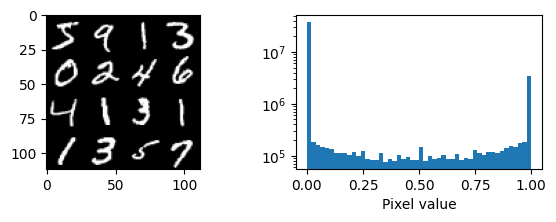

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

def rough_inspection(dataset, n_fig=4):
    figure = np.concatenate([np.reshape(dataset[n_fig*i:n_fig*(i+1)], (n_fig*28, 28)) for i in range(n_fig)], axis=1)

    plt.figure(figsize=(7,2))
    plt.subplot(1, 2, 1)
    plt.imshow(figure, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(dataset.flatten(), bins=50)
    plt.yscale('log')
    plt.xlabel("Pixel value")
    plt.show()
    
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
train_idx = sum([np.arange(len(y_train))[y_train == i].tolist()[:4] for i in range(10)], [])
test_idx = sum([np.arange(len(y_test))[y_test == i].tolist()[:4] for i in range(10)], [])

Lx_train = x_train[train_idx]
Lx_test = x_test[test_idx]
Ly_train = y_train[train_idx]
Ly_test = y_test[test_idx]

px_train = (x_train / x_train.max())
px_test = (x_test / x_train.max()) 
pLx_train = (Lx_train / x_train.max())
pLx_test = (Lx_test / x_train.max()) 

py_train = np.stack([Ly_train == i for i in range(10)], axis=1)
py_test = np.stack([Ly_test == i for i in range(10)], axis=1)

rough_inspection(px_train)

# A Convolutional Autoencoder

Let's drop the Dense layers and let's define a Convolutional Autoencoder.

This time we will define two networks, one for the Encoder and one for the decoder and we will use them separately.

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, Flatten, LeakyReLU, Rescaling, Activation
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam

###############################
## Definition of the ENCODER 

encoder = Sequential([
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=7, padding='same', activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=5, padding='same', activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=5, padding='same', activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='tanh', kernel_initializer='he_normal'),
    Dense(128, activation='tanh', kernel_initializer='he_normal'),
    Dense(2, activation='linear')
], name="encoder")

encoder.build(input_shape=(None, 28, 28))
display(encoder.summary())

###############################
## Definition of the DECODER

decoder = Sequential([
    Dense(128, activation='tanh', kernel_initializer='he_normal'),
    Dense(128, activation='tanh', kernel_initializer='he_normal'),
    Dense(28//4*28//4*16, activation='tanh'),
    Reshape((28//4, 28//4, 16)),
    Conv2DTranspose(32, kernel_size=(5, 5), padding='same', kernel_initializer='he_normal', activation='tanh'),
    UpSampling2D(size=(2 ,2)),
    Conv2DTranspose(32, kernel_size=(5, 5), padding='same', kernel_initializer='he_normal', activation='tanh'),
    UpSampling2D(size=(2 ,2)),
    Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='sigmoid'),
    Reshape((28,28)),
], name="decoder")
decoder.build(input_shape=encoder.output_shape)

display(decoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          2563

2023-06-04 15:53:51.809460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 15:53:51.828905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 15:53:51.830559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 15:53:51.832679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

None

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               384       
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 784)               101136    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 32)         12832     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0         
 )                                                         

None

## Let's make the training loop explicit

Instead of using the `fit` function provided by Keras, let's have a look to the inner logic of the training loop.
While not particularly useful for this application, in itself, it is worth starting with a simple case that then we will make more complex.

  0%|          | 0/50 [00:00<?, ?it/s]2023-06-04 15:53:53.452442: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-06-04 15:53:54.483647: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 50/50 [03:45<00:00,  4.51s/it]


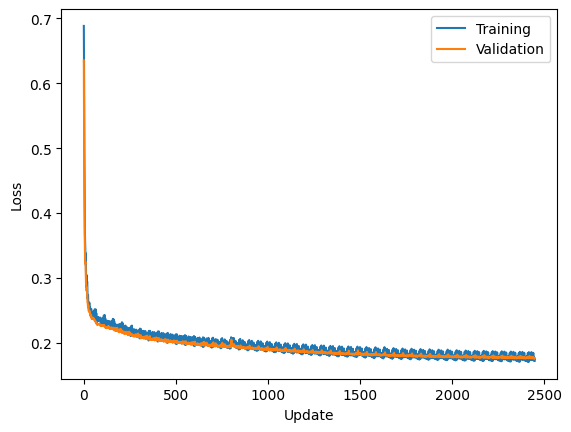

In [3]:
## Define the optimizer
ae_optimizer = Adam(5e-4)

## Define a function to update the weights on a chunk of the training dataset
def ae_train_step(train_data):
    ## Retrieve the trainable weights of the two networks (encoder and decoder)
    enc_vars = encoder.trainable_weights
    dec_vars = decoder.trainable_weights

    ## Combines them into the whole list of variables
    ae_vars = enc_vars + dec_vars

    ## Create a GradientTape to record the gradient of the loss with respect to the 
    ## traniable weights.
    with tf.GradientTape() as tp: 
        ## Then we describe the operations part of the model: encoding first
        encoded = encoder(train_data)
        ## deconding then
        decoded = decoder(encoded)

        ## And finally, we compute the loss as a BinaryCrossentropy.
        loss = BinaryCrossentropy()(train_data, decoded) 

        
    ## Once the gradients are recorded on tape, we can compute them
    ae_grads = tp.gradient(loss, ae_vars)
    
    ## and use them to update the weights
    ae_optimizer.apply_gradients(zip(ae_grads, ae_vars))

    return loss

## We also define a test step which replicates the operations performed during the 
## training, but without updating the weights nor computing the gradients.
def ae_test_step(test_data):
    encoded = encoder(test_data)
    decoded = decoder(encoded)

    loss = BinaryCrossentropy()(test_data, decoded)

    return loss


## Then we start the training loop, keeping track of the losses for each update.
losses = []
val_losses = []

## Split the training dataset in chunks (or batches) and uploads them to GPU
chunks = [tf.constant(c) for c in np.split(px_train, 50)[:-1]]
## Selects a few samples from the validation sample to monitor overtraining
val_chunk = tf.constant(px_test[:1000])


## Reset the weights
from tensorflow.keras.models import clone_model
decoder = clone_model(decoder)
encoder = clone_model(encoder)

## Creates a progress bar while looping through the epochs
from tqdm import trange
for epoch in trange(50):
    ## Loop over the batches of the training sample
    for chunk in chunks: 
        losses.append    (   ae_train_step(chunk)      )
        val_losses.append(   ae_test_step(val_chunk)   )

## Plot the loss during the training
plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Update")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Latent space

As we have discussed in the previous Lecture, let's have a look to the latent space of this new Convolutional Autoencoder

313/313 [==============================] - 1s 2ms/step


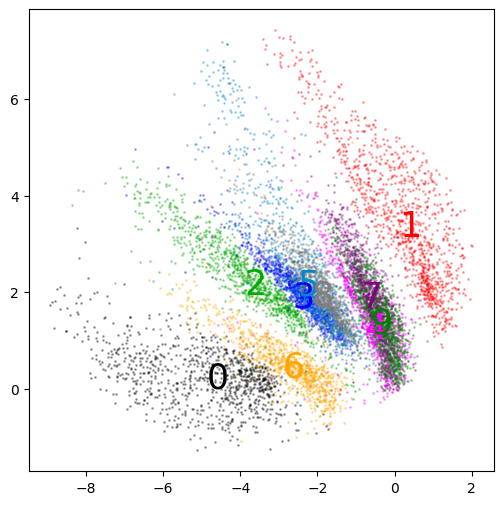

In [4]:
encoded_test = encoder.predict(px_test)


u, v = encoded_test.T
plt.figure(figsize=(6,6))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
    plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
    u_mean = np.quantile(u[y_test == digit], 0.5)
    v_mean = np.quantile(v[y_test == digit], 0.5)
    plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

plt.show()

## Reconstruction
And let's represent once more the reconstruction error.

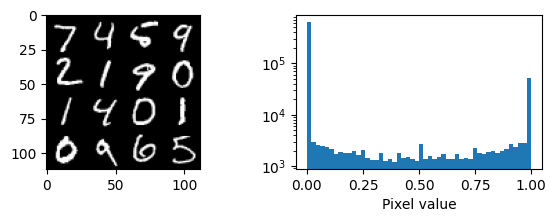

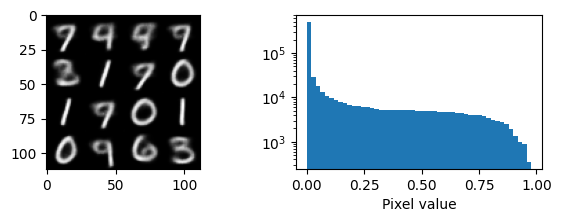

In [5]:
reconstructed = decoder(encoder(val_chunk)).numpy()
rough_inspection(val_chunk.numpy())
rough_inspection(reconstructed)

# Using the labels to pin digits to the latent space

We would like now to take the autoencoder and force the mapping of digits in specific positions of the latent space.
This might be useful for mainly two reasons:
 * we plan to create some parametric model to desctibe our encoded dataset, or to interpret it with simple technique;
 * we are trying to improve the performance of the autoencoder by making it informed of the label of the datasets;
 
In this example, we will try to position the $L$-th digit in the $(u,v)$ latent space at
$$
\left\{
\begin{array}{l}
u = \cos\left[\left(\frac{2\pi}{10}L\right)\right] \\
v = \sin\left[\left(\frac{2\pi}{10}L\right)\right] \\
\end{array}
\right.
$$

To obtain this result we redefine the loss function of the autoencoder including a term that penalizes mappings of an image from the label identified by its label.
$$
\mathcal L = \mathcal L_{\mathsf{reco}} + \lambda \mathcal L_{\mathsf{pin}}
$$
where 
 * $\lambda \in \mathbb R$ is a hyperparameter defining the relative importance of the two contributions to the loss
 * $\displaystyle \mathcal L_{\mathsf{reco}} = -\sum_{i,p} [ b_{i,p} \log(\hat b_{i, p})  + (1-b_{i,p})\log(\hat b_{i, p}) ] $ 
 * $\displaystyle \mathcal L_{\mathsf{pin}} = \sum_{i} \left\{
     \left( \hat u_i - \cos\left[\left(\frac{2\pi}{10}L\right)\right] \right)^2 + \left( \hat v_i - \sin\left[\left(\frac{2\pi}{10}L\right)\right] \right)^2
     \right\} $
     
with $i$ running on the *instance* (which is the pair figure-label); $p$ running on the pixel; $b_{i,p}$ being the brightness of the $p$-th pixel of the $i$-th image; $\hat b_{i,p}$ its predicted value as obtained from the autoencoder; $\hat u_i$ and $\hat v_i$ the coordinates of the latent space as obtained by the autoencoder running on on the $i$-th figure.



100%|██████████| 30/30 [01:54<00:00,  3.83s/it]


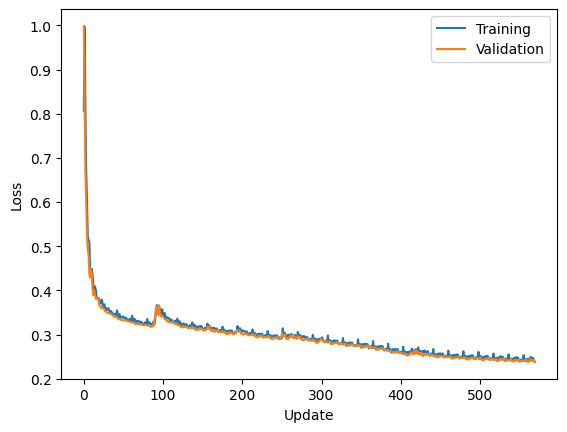

In [6]:
ae_optimizer = Adam(1e-3)

def ae_train_step(train_data, labels):
    enc_vars = encoder.trainable_weights
    dec_vars = decoder.trainable_weights

    ae_vars = enc_vars + dec_vars

    with tf.GradientTape() as tp:
        encoded = encoder(train_data)
        decoded = decoder(encoded)

        ## Compute the desired position in the latent space, given the label
        pins = tf.stack([tf.math.cos(2*np.pi*labels/10), tf.math.sin(2*np.pi*labels/10)], axis=1)
        
        ## Compute the contribution L_pin to the loss 
        labeled_loss = tf.reduce_mean(
            tf.where(tf.math.is_finite(labels), tf.linalg.norm(encoded - pins, axis=1), 0.)
        )
        
        ## Combines the two losses L_reco and L_pin, with lambda = 0.1
        loss = BinaryCrossentropy()(train_data, decoded) + 0.1*labeled_loss

    ae_grads = tp.gradient(loss, ae_vars)
    ae_optimizer.apply_gradients(zip(ae_grads, ae_vars))

    return loss

def ae_test_step(test_data, labels):
    encoded = encoder(test_data)
    decoded = decoder(encoded)

    pins = tf.stack([tf.math.cos(2*np.pi*labels/10), tf.math.sin(2*np.pi*labels/10)], axis=1)
    labeled_loss = tf.reduce_mean(
        tf.where(tf.math.is_finite(labels), tf.linalg.norm(encoded - pins, axis=1), 0.)
    )
        
    loss = BinaryCrossentropy()(test_data, decoded) + 0.1*labeled_loss

    return loss


losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 20)[:-1]]
label_chunks = [tf.constant(c, dtype=tf.float32) for c in np.split(y_train, 20)[:-1]]

val_chunk = tf.constant(px_test[:1000])
val_label = tf.constant(y_test[:1000], dtype=tf.float32)


## Reset the weights
from tensorflow.keras.models import clone_model
decoder = clone_model(decoder)
encoder = clone_model(encoder)

from tqdm import trange
for epoch in trange(30):
    for chunk, label_chunk in zip(chunks, label_chunks):
        losses.append(ae_train_step(chunk, label_chunk))
        val_losses.append(ae_test_step(val_chunk, val_label))

plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Update")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Resulting, engineered latent space and improvement on the reconstruction error

313/313 [==============================] - 0s 1ms/step


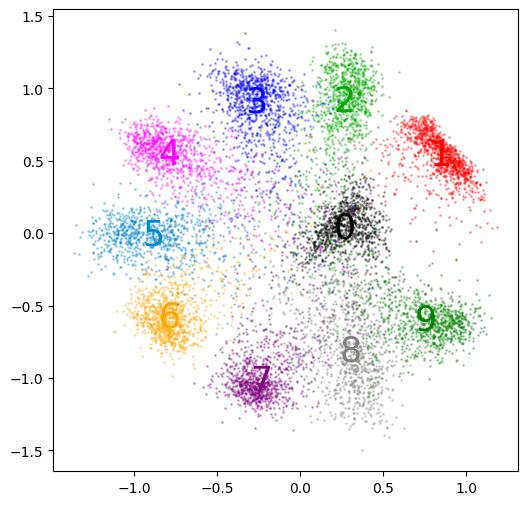

In [7]:
encoded_test = encoder.predict(px_test)

u, v = encoded_test.T
plt.figure(figsize=(6,6))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
    plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
    u_mean = np.quantile(u[y_test == digit], 0.5)
    v_mean = np.quantile(v[y_test == digit], 0.5)
    plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

plt.show()

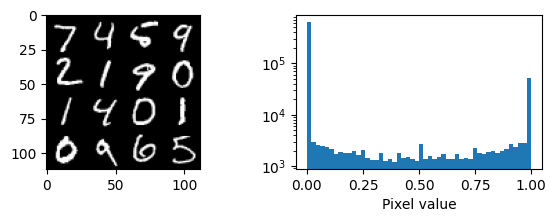

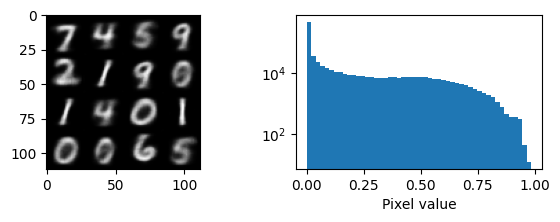

In [8]:
reconstructed = decoder(encoder(val_chunk)).numpy()
rough_inspection(val_chunk.numpy())
rough_inspection(reconstructed)

# Adversarial Neural Networks (and Adversarial Autoencoders)

While we managed to force some labels to be mapped in fixed regions of the latent space, we have no control on the actual distribution of the dataset in the latent space. Some clusters are larger, others are thinner. Some are far from each other (for example 6 and 7), others are much closer (for example 9 and 8). 

It would be interesting to force the distribution in the latent space to be as close as possible to some arbitrary distribution, let's say a Gaussian centered in the origin. 

There are several possible techniques to achieve such a result, since we are exploring here the concept of *Systems of Neural Networks* we will do it by defining a third neural network, entering the interplay between encoder and decoder to push the training towards a solution in which the distribution in the latent space is as close as possible to a Gaussian.

In practice, we define a third Neural Network that tries to distinguish the pairs obtained by the encoder from a random normally-distributed sample. Then we will train encoder to fool this classifier, increasing its loss.

This is a form of adversarial training in which there are two players (in this case the encoder and the classifier) that compete in a sort of game trying to reach an equilibrium at which none of the two player can improve its performance without worsening the performance of the other.


## The Classifier
Let's create the aversarial player, a classifier applied to the latent space.  It can be a simple MLP.

In [9]:
classifier = Sequential()
classifier.add(Dense(128, activation='tanh', kernel_initializer='he_normal'))
classifier.add(Dense(128, activation='tanh', kernel_initializer='he_normal'))
classifier.add(Dense(128, activation='tanh', kernel_initializer='he_normal'))
classifier.add(Dense(128, activation='tanh', kernel_initializer='he_normal'))
classifier.add(Dense(128, activation='tanh', kernel_initializer='he_normal'))
classifier.add(Dense(1, activation='sigmoid'))

classifier.build(input_shape=(None, 2))
display(classifier)

Then we modify the training loop to train the three networks simultaneously.

100%|██████████| 50/50 [05:25<00:00,  6.51s/it]


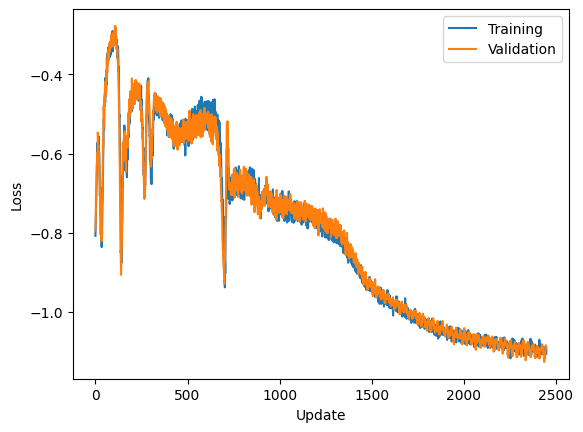

In [10]:
## Note that we are now using two different optimizers, with different learning rates, for the two networks
ae_optimizer = Adam(1e-5)
adv_optimizer = Adam(1e-4)

def ae_train_step(train_data):
    ## We define here the shortcuts for the trainable weights of the three nets
    enc_vars = encoder.trainable_weights
    dec_vars = decoder.trainable_weights
    adv_vars = classifier.trainable_weights

    ae_vars = enc_vars + dec_vars

    
    with tf.GradientTape() as tp, tf.GradientTape() as adv_tp:
        ## We define the forward step: encode, decode and then classify
        encoded = encoder(train_data)
        decoded = decoder(encoded)
        classif = classifier(encoded)
        
        ## We define a binary cross-entropy loss for our adversarial classifier
        adv_loss = (
            BinaryCrossentropy(label_smoothing=0.01)(tf.ones_like(classif), classif) + 
            BinaryCrossentropy(label_smoothing=0.01)(tf.zeros_like(classif), classifier(tf.random.normal(tf.shape(encoded))))
        )
        
        ## Finally we subtract the adversarial loss to the reconstruction loss (possibly weighted by a constant)
        loss = BinaryCrossentropy()(train_data, decoded) - adv_loss

    ## Gradients are now computed only for those loss, and with respect to those variables where they make sense
    ae_grads = tp.gradient(loss, ae_vars)
    adv_grads = adv_tp.gradient(adv_loss, adv_vars)
    
    ## And applied to the weights of the two networks separately
    ae_optimizer.apply_gradients(zip(ae_grads, ae_vars))
    adv_optimizer.apply_gradients(zip(adv_grads, adv_vars))

    return loss

def ae_test_step(test_data):
    encoded = encoder(test_data)
    decoded = decoder(encoded)
    classif = classifier(encoded)

    adv_loss = (
            BinaryCrossentropy(label_smoothing=0.01)(tf.ones_like(classif), classif) + 
            BinaryCrossentropy(label_smoothing=0.01)(tf.zeros_like(classif), classifier(tf.random.normal(tf.shape(encoded))))
        )
        
    loss = BinaryCrossentropy()(test_data, decoded) - adv_loss

    return loss


losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 50)[:-1]]

val_chunk = tf.constant(px_test[:1000])


## Reset the weights
from tensorflow.keras.models import clone_model
decoder = clone_model(decoder)
encoder = clone_model(encoder)
classifier = clone_model(classifier)

from tqdm import trange
for epoch in trange(50):
    for chunk in chunks:
        losses.append(ae_train_step(chunk))
        val_losses.append(ae_test_step(val_chunk))

plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Update")
plt.ylabel("Loss")

plt.legend()
plt.show()

## Visualizing the latent space

If we visualize the distribution in the latent space we do now observe a more centered distribution, which is rather similar to our target normal distribution (though more tuning and longer training might improve things further).

313/313 [==============================] - 0s 1ms/step


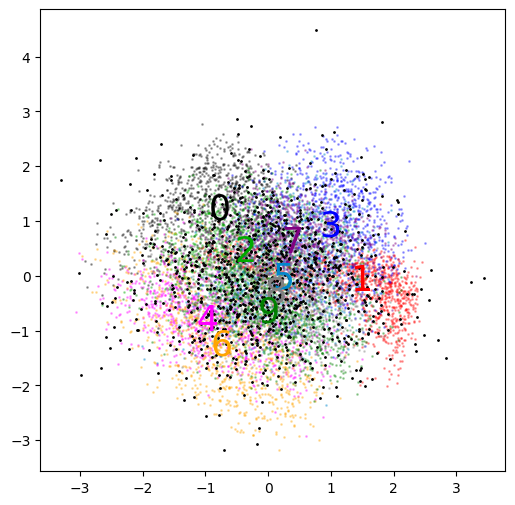

In [11]:
encoded_test = encoder.predict(px_test)
u, v = encoded_test.T
plt.figure(figsize=(6,6))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
    plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
    u_mean = np.quantile(u[y_test == digit], 0.5)
    v_mean = np.quantile(v[y_test == digit], 0.5)
    plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')
plt.plot(np.random.normal(0.0, 1, 1000), np.random.normal(0.0, 1, 1000), 'ko', markersize=1)

plt.show()

## Anomaly detection based on the latent space

Now, we can associate a measure of density to the latent space. We know that smaller values of $u$ and $v$ are associated to larger probability density. 
We can therefore expect that anomalies are mapped further from the center, as they were ignored during the adversarial training that was pushing the solutions towards the center of the latent space.

Let's repeat the exercise with the Extended MNIST, presenting letters to an adversarial autoencoder trained on digits.

In [12]:
!conda run -p /envs/root pip install -q emnist
import emnist
letters, _ = emnist.extract_training_samples('letters')
digits, _ = emnist.extract_training_samples('digits')

letters = letters[:30000]/255


938/938 [==============================] - 1s 1ms/step


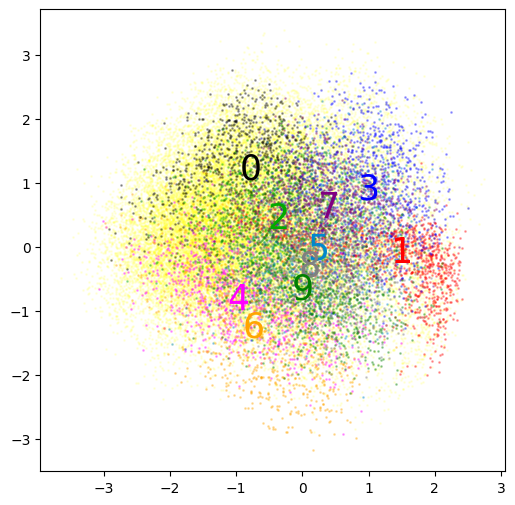

In [13]:
encoded_test = encoder.predict(px_test)
encoded_letters = encoder.predict(letters)

u, v = encoded_test.T
plt.figure(figsize=(6,6))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
    plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
    u_mean = np.quantile(u[y_test == digit], 0.5)
    v_mean = np.quantile(v[y_test == digit], 0.5)
    plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

plt.plot(encoded_letters[:,0], encoded_letters[:,1], 'o', markersize=1, alpha=0.1, color='yellow', zorder=-100)
    
plt.show()

Letters (in yellow) are indeed mapped further from the center. We can try to convert this into a test statistic to be used for anomaly detection.
For example, one can take the distance from the center.

Below we show the histogram of the distance from the center as obtained from the trained adversarial autoencoder.

Once again, relaxing the constraint on the number of dimensions of the latent space and on the duration of the training one may improve significantly the discrimination between digits and letters.

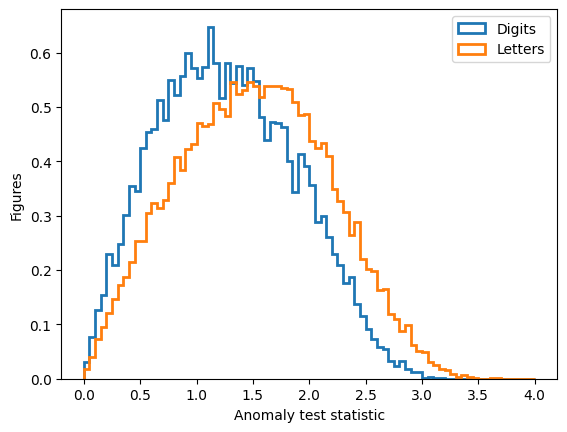

In [14]:
t_test = np.linalg.norm(encoded_test, axis=1)
t_letters = np.linalg.norm(encoded_letters, axis=1)

bins = np.linspace(0, 4, 81)
plt.hist(t_test, bins=bins, label="Digits", density=True, histtype='step', linewidth=2)
plt.hist(t_letters, bins=bins, label="Letters", density=True, histtype='step', linewidth=2)
plt.xlabel("Anomaly test statistic")
plt.ylabel("Figures")
plt.legend()
plt.show()

# Conclusion

In this second notebook we explored in more detail the Convolutional Autoencoder and we learned how to train them making the training loop explicit.
Then we modified the training loop to introduce additional terms to the loss function, for example by pinning the encoded values to special positions in the parameter space.

Finally, we introduced the concept of adversarial training, introducing a third neural network trained to distinguish encoded entries in the latent space from a centered Gaussian distribution. We used its loss function to train the encoder to map the input dataset into a distribution as close as possible to the target distribution and we observed that introducing a notion of density in the latent space enables a performance improvement in anomaly detection tasks.

Adversarial training is widely used in High Energy Physics to introduce constraints to the optimization of a given algorithm.
This approach is sometimes called [Pivoting](https://arxiv.org/abs/1611.01046), sometimes [Domain Adaptation](https://arxiv.org/abs/2207.09293).
